# `CIFAR10` Image Classification Challenge (Version-0.1) Dense Layer

### Setup

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

Here we import necessary packages. Notice `%tensorflow_version 2.x` command, with this command, we can import `TensorFlow 2.x` version inside `colab`.

In [0]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as tf_hub

TensorFlow 2.x selected.


In [0]:
from matplotlib import style

import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import urllib3

In [0]:
logger = tf.get_logger()

logger.setLevel(logging.ERROR)
style.use('ggplot')
tfds.disable_progress_bar()
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

### Loading the Dataset --> `tensorflow_datasets` --> `CIFAR10`

This is the heart of the dataset divison. With this code below, we `subsplit` the whole `cifar10` dataset into three divisons namely, 

* `train_dataset` which has `70%` of `ALL`, 
* `valid_dataset` which has `20%` of `ALL` and finally, 
* `test_dataset` which has `10%` of `ALL`. 

The point of this subsplit is to make sure our models always acts on unseen data, which is very important to generalize the data. 

In machine learning, __Generalization__ is an act of __Learning__ but not <i>memorization</i>.

In [0]:
splitting = tfds.Split.ALL.subsplit(weighted=(70, 20, 10))
splitting

(NamedSplitAll()(tfds.percent[0:70]),
 NamedSplitAll()(tfds.percent[70:90]),
 NamedSplitAll()(tfds.percent[90:100]))

In [0]:
dataset, dataset_info = tfds.load(name='cifar10', split=splitting, as_supervised=True, with_info=True)

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/1.0.2. Subsequent calls will reuse this data.


In [0]:
dataset_info

tfds.core.DatasetInfo(
    name='cifar10',
    version=1.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    urls=['https://www.cs.toronto.edu/~kriz/cifar.html'],
    features=FeaturesDict({
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

In [0]:
train_dataset, valid_dataset, test_dataset = dataset

In [0]:
print(train_dataset)
print(valid_dataset)
print(test_dataset)

<_OptionsDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>


In `cifar10` dataset, we mainly have 10 classes, which are recognised as integers. Now our challenge is to make the our `classify` those images based on `confidence` value which is between `0` to `1` (probability of certainty).

For more details about the dataset, please check these links, [cifar10 TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/cifar10) and [cifar10 Author](https://www.cs.toronto.edu/~kriz/cifar.html).

In [0]:
num_classes = dataset_info.features['label'].num_classes
class_names = np.array(dataset_info.features['label'].names)

num_training_examples = 0
for example_tr in train_dataset:
  num_training_examples += 1

num_validation_examples = 0
for example_val in valid_dataset:
  num_validation_examples += 1

num_testing_examples = 0
for example_tes in test_dataset:
  num_testing_examples += 1

print("Number of Classes : {}\n".format(num_classes))

for i, c_name in enumerate(class_names):
  print("{}  --> {}".format(i, c_name))

print("\nNumber of examples in training dataset   : {}".format(num_training_examples))
print("Number of examples in validation dataset : {}".format(num_validation_examples))
print("Number of examples in testing dataset    : {}".format(num_testing_examples))

Number of Classes : 10

0  --> airplane
1  --> automobile
2  --> bird
3  --> cat
4  --> deer
5  --> dog
6  --> frog
7  --> horse
8  --> ship
9  --> truck

Number of examples in training dataset   : 42000
Number of examples in validation dataset : 12000
Number of examples in testing dataset    : 6000


In [0]:
for train_img, train_lab in train_dataset.take(1):
  break

print("{}".format(train_img))
print("{}".format(train_lab))

[[[ 97 109  91]
  [ 97 113  93]
  [ 91 114  89]
  ...
  [ 59  77  84]
  [ 44  60  63]
  [ 43  55  59]]

 [[100 112  97]
  [ 97 111  95]
  [ 86 110  85]
  ...
  [ 47  62  67]
  [ 49  65  72]
  [ 56  69  80]]

 [[100 115 100]
  [ 99 113 105]
  [ 87 111  95]
  ...
  [ 46  61  65]
  [ 51  69  76]
  [ 63  79  89]]

 ...

 [[119 129 134]
  [110 121 123]
  [107 120 120]
  ...
  [ 98 123 129]
  [119 140 164]
  [124 147 175]]

 [[116 127 128]
  [111 124 129]
  [106 121 124]
  ...
  [113 146 165]
  [117 144 171]
  [114 138 158]]

 [[104 115 111]
  [104 116 114]
  [105 124 125]
  ...
  [129 163 192]
  [128 157 189]
  [118 141 163]]]
2


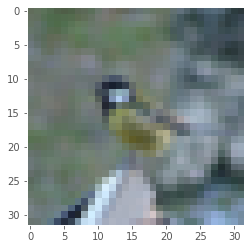

In [0]:
train_img = train_img.numpy().reshape((32, 32, 3))

plt.imshow(train_img)
plt.grid(False)
plt.show()

### Normalization
Normalization is a good practice to remove uncertain outliers. It also ensures the data is distributed in a common scale and avoid distortions in the ranges. Since `cifar10` is colored image dataset ranging from `0` to `255`, we normalize each `pixel` by dividing it by `255` to bring every pixel value within range of `0` and `1`.

In [0]:
def normalization(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255
  return image, label

In [0]:
for train_img, train_lab in train_dataset.take(1):
  break

In [0]:
train_img, train_lab = normalization(train_img, train_lab)

In [0]:
print("{}".format(train_img))
print("{}".format(train_lab))

[[[0.38039216 0.42745098 0.35686275]
  [0.38039216 0.44313726 0.3647059 ]
  [0.35686275 0.44705883 0.34901962]
  ...
  [0.23137255 0.3019608  0.32941177]
  [0.17254902 0.23529412 0.24705882]
  [0.16862746 0.21568628 0.23137255]]

 [[0.39215687 0.4392157  0.38039216]
  [0.38039216 0.43529412 0.37254903]
  [0.3372549  0.43137255 0.33333334]
  ...
  [0.18431373 0.24313726 0.2627451 ]
  [0.19215687 0.25490198 0.28235295]
  [0.21960784 0.27058825 0.3137255 ]]

 [[0.39215687 0.4509804  0.39215687]
  [0.3882353  0.44313726 0.4117647 ]
  [0.34117648 0.43529412 0.37254903]
  ...
  [0.18039216 0.23921569 0.25490198]
  [0.2        0.27058825 0.29803923]
  [0.24705882 0.30980393 0.34901962]]

 ...

 [[0.46666667 0.5058824  0.5254902 ]
  [0.43137255 0.4745098  0.48235294]
  [0.41960785 0.47058824 0.47058824]
  ...
  [0.38431373 0.48235294 0.5058824 ]
  [0.46666667 0.54901963 0.6431373 ]
  [0.4862745  0.5764706  0.6862745 ]]

 [[0.45490196 0.49803922 0.5019608 ]
  [0.43529412 0.4862745  0.5058824 ]


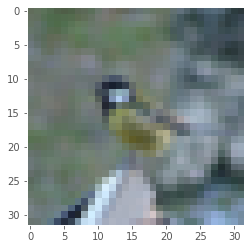

In [0]:
train_img = train_img.numpy().reshape((32, 32, 3))

plt.imshow(train_img)
plt.grid(False)
plt.show()

In [0]:
for valid_img, valid_lab in valid_dataset.take(1):
  break

In [0]:
print("{}".format(valid_img))
print("{}".format(valid_lab))

[[[ 35  48  30]
  [ 30  45  24]
  [ 44  62  37]
  ...
  [212 198 174]
  [217 204 180]
  [219 207 183]]

 [[ 38  50  33]
  [ 32  46  27]
  [ 39  55  33]
  ...
  [214 199 177]
  [219 204 183]
  [222 208 186]]

 [[ 36  47  33]
  [ 28  40  26]
  [ 35  49  30]
  ...
  [220 207 187]
  [222 210 190]
  [224 211 192]]

 ...

 [[ 32  30  30]
  [ 26  26  27]
  [ 22  22  24]
  ...
  [165 163 174]
  [156 151 164]
  [159 154 166]]

 [[ 48  44  54]
  [ 46  44  56]
  [ 43  42  54]
  ...
  [145 145 160]
  [149 147 160]
  [160 158 167]]

 [[ 60  60  73]
  [ 61  63  77]
  [ 61  65  78]
  ...
  [149 148 162]
  [162 159 168]
  [198 196 197]]]
1


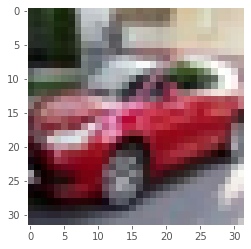

In [0]:
valid_img = valid_img.numpy().reshape((32, 32, 3))

plt.imshow(valid_img)
plt.grid(False)
plt.show()

In [0]:
for test_img, test_lab in test_dataset.take(1):
  break

In [0]:
print("{}".format(test_img))
print("{}".format(test_lab))

[[[  1  16   5]
  [  6  21  10]
  [  6  22  11]
  ...
  [  2   7   1]
  [  2   7   1]
  [  0   5   0]]

 [[  2  17   6]
  [ 11  27  17]
  [ 10  26  15]
  ...
  [  2   7   1]
  [  2   7   1]
  [  0   5   0]]

 [[  4  20   9]
  [ 11  27  16]
  [  5  20   9]
  ...
  [  1   6   0]
  [  2   7   1]
  [  1   6   0]]

 ...

 [[ 93  85  61]
  [ 78  68  43]
  [ 60  55  34]
  ...
  [ 54  51  42]
  [ 41  39  31]
  [ 48  45  36]]

 [[102  93  69]
  [ 91  79  53]
  [ 73  67  46]
  ...
  [ 58  55  45]
  [ 34  31  23]
  [ 23  20  11]]

 [[ 99  90  66]
  [ 89  78  52]
  [ 81  76  54]
  ...
  [ 66  63  53]
  [ 56  53  45]
  [ 41  38  29]]]
5


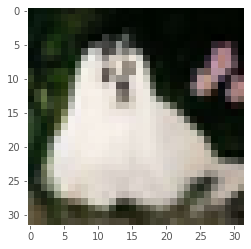

In [0]:
test_img = test_img.numpy().reshape((32, 32, 3))

plt.imshow(test_img)
plt.grid(False)
plt.show()

### Data Normalization
Now we `map` our datasets and `cache` them for optimization and faster loading.

In [0]:
train_dataset = train_dataset.map(map_func=normalization)
valid_dataset = valid_dataset.map(map_func=normalization)
test_dataset = test_dataset.map(map_func=normalization)

train_dataset = train_dataset.cache()
valid_dataset = valid_dataset.cache()
test_dataset = test_dataset.cache()

### Training and Validation Images
We just plot first `25` images both from `train_dataset` and `valid_dataset`.

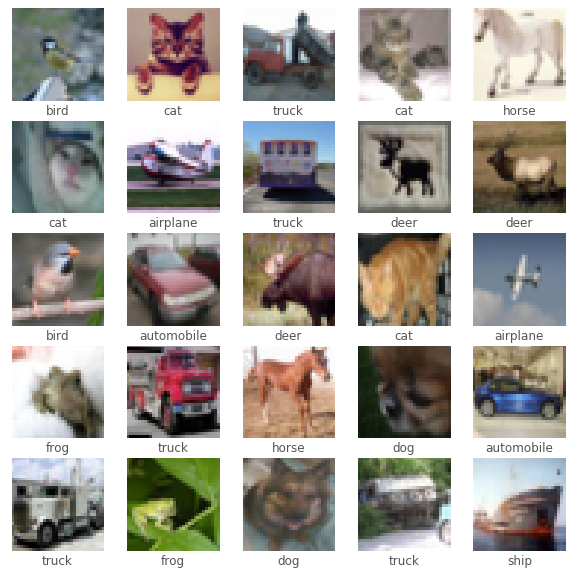

In [0]:
plt.figure(figsize=(10, 10))

i = 0
for train_img, train_lab in train_dataset.take(count=25):
  train_img = train_img.numpy().reshape(32, 32, 3)
  
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel("{}".format(class_names[train_lab]))
  plt.imshow(train_img)
  plt.grid(False)
  i += 1

plt.show()

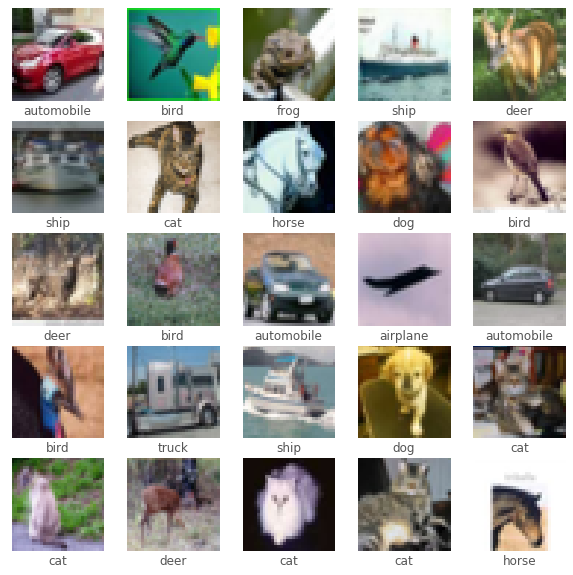

In [0]:
plt.figure(figsize=(10, 10))

i = 0
for valid_img, valid_lab in valid_dataset.take(count=25):
  valid_img = valid_img.numpy().reshape((32, 32, 3))

  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel("{}".format(class_names[valid_lab]))
  plt.imshow(valid_img)
  plt.grid(False)
  i += 1

plt.show()

### Preparation of Loaded Data
This is a fundamental phase in machine learning and deep learning. Preparation of `dataset` involves, 
* __`cleaning`__ : to remove `NaN` or `NA` values.
* __`normalizing`__ : to bring the data points into common scale and avoid distortions in the range.
* __`shuffling`__ : this is done to randmize the data just to ensure model gets every aspect of data while we train. This is helpful when we feed seasonal data to our model. So `randomization` helps to obtain every essence seasonal aspect when we are training. We __don't__ randomize our `valid_dataset` and `test_dataset`.
* __`batching`__ : this is useful in the training phase, a `batch` is an extra dimension in the `input_shape` which groups the set of data points. Here we `batch` our data into groups of `32` (just some positive integer, again it's a `hyper_parameter` which can be tuned).

Notice we use a `prefetch` method at the end, prefetch returns a `batch` of data. While our model is busy learning a batch say `#batch_1`, `prefetch()` prepares another batch say `#batch_2` to optimize the performace. And the `GPU` is always busy.

In [0]:
BATCH_SIZE = 32
IMG_SIZE = 32

In [0]:
training_batches = train_dataset.shuffle(buffer_size=num_training_examples//4).batch(batch_size=BATCH_SIZE).prefetch(1)
validation_batches = valid_dataset.batch(batch_size=BATCH_SIZE).prefetch(1)
testing_batches = test_dataset.batch(batch_size=BATCH_SIZE)

In [0]:
train_img_batch, train_lab_batch = next(iter(training_batches.take(1)))

In [0]:
print(train_img_batch.shape)
print(train_lab_batch.shape)

(32, 32, 32, 3)
(32,)


### Fabricate the Model
This has to be made deliberately and it is the part, where every ML engineer spends his time. Tuning hyper parameters. `Flatten` layers flattens our input images of `input_shape = (32, 32, 3)` to `1D` array and is passed on to subsequent `Dense` layers. Remember the 1st layer is __not__ input layer. It is a flattening layer. We just need to specify the of input. The last layer is an output layer with `units = 10` (units are no. of `nodes` in a layer) since we have 10 classes. 

Every node in layer uses `activation` (a value inside a node). Three activation functions used, 
1. `tf.nn.relu` : this is an activatin function that lies between `HL2` and `HL3` and transform the outputs of nodes of `HL2` to learn non-linear patterns from the data.
2. `tf.nn.relu` : this is an activatin function that lies between `HL3` and `OL` and transforms the outputs of nodes of `HL3` to learn non-linear patterns from the data. 
3. `tf.nn.softmax` : this activation is performed when `OL` produces output. This function, returns `10 confidence` values (probability of certainty), because we have 10 units in `OL`, whose confidence is larger, that class is predicted.

In [0]:
cifar10_model_v_0_1 = tf.keras.Sequential(layers=[
  tf.keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)), 
  tf.keras.layers.Dense(units=25, activation=tf.nn.relu), 
  tf.keras.layers.Dense(units=50, activation=tf.nn.relu), 
  tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)
])

Here we create `callback` from `tf.keras` to schedule our `learning_rate` (basically the gradient steps). We do this, just to know which `learning_rate` is best for model performance in terms of reduction in `loss` and increment in `accuracy`.

There are two things, `training_iteration` and `epoch`. Training iteration is referred when we are training the model for each data point, whereas the epoch is referred as no. of times the model in trained. This is interpreted as nested `for` loop.

```python
# Pythonic representation,

for epoch in epochs:
    for training in epoch:
        # training for each data point.
```



In this snippet, for each `epoch`, `learning_rate` is slightly increased. So initially model `loss` is moderate and then happens to decrease and gradually shoots up (because the step-size is more).

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    schedule=lambda epoch: 1e-6 * 10**(epoch / 30))

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [0]:
cifar10_model_v_0_1.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [0]:
cifar10_model_v_0_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 25)                76825     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1300      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
Total params: 78,635
Trainable params: 78,635
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = cifar10_model_v_0_1.fit(training_batches, epochs=150, callbacks=[lr_schedule])

Epoch 1/150
1313/1313 [==============================] - 23s 17ms/step - loss: 2.2930 - accuracy: 0.1323
Epoch 2/150
1313/1313 [==============================] - 5s 4ms/step - loss: 2.2615 - accuracy: 0.1495
Epoch 3/150
1313/1313 [==============================] - 5s 4ms/step - loss: 2.2451 - accuracy: 0.1571
Epoch 4/150
1313/1313 [==============================] - 5s 4ms/step - loss: 2.2280 - accuracy: 0.1656
Epoch 5/150
1313/1313 [==============================] - 5s 4ms/step - loss: 2.2115 - accuracy: 0.1738
Epoch 6/150
1313/1313 [==============================] - 5s 4ms/step - loss: 2.1959 - accuracy: 0.1827
Epoch 7/150
1313/1313 [==============================] - 5s 4ms/step - loss: 2.1804 - accuracy: 0.1901
Epoch 8/150
1313/1313 [==============================] - 5s 4ms/step - loss: 2.1645 - accuracy: 0.1974
Epoch 9/150
1313/1313 [==============================] - 5s 4ms/step - loss: 2.1483 - accuracy: 0.2048
Epoch 10/150
1313/1313 [==============================] - 5s 3ms/step -

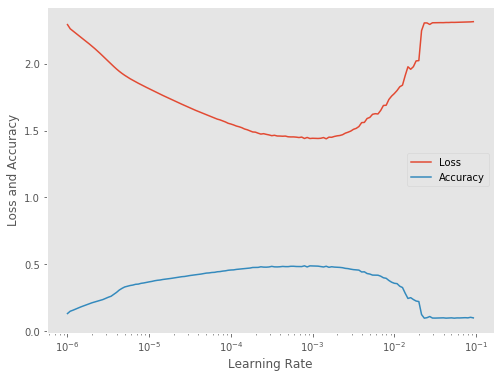

In [0]:
plt.figure(figsize=(8, 6))

plt.semilogx(history.history['lr'], history.history['loss'], label="Loss")
plt.semilogx(history.history['lr'], history.history['accuracy'], label="Accuracy")
plt.xlabel("Learning Rate")
plt.ylabel("Loss and Accuracy")
plt.grid(False)
plt.legend()
plt.show()

We witness from the above figure, intially `loss` tend to descend until `1e-3`, same applies for accuracy, it ascended until `1e-3`. After that, loss soared and accuracy declined. So, the `learning_rate` here in this case would be `1e-3` which is $10^{-3}$.

If we deliberately interpret the graph, both `loss` and `accuracy` did not improve much. For `learning_rate = 1e-3` we got `loss = 1.5..` and `accuracy = 0.4.. (40%)`. Dense model is not up to the mark, but its fine.

In [0]:
cifar10_model_v_0_1 = tf.keras.Sequential(layers=[
  tf.keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)), 
  tf.keras.layers.Dense(units=512, activation=tf.nn.relu), 
  tf.keras.layers.Dense(units=250, activation=tf.nn.relu), 
  tf.keras.layers.Dense(units=150, activation=tf.nn.sigmoid), 
  tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)
])

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_fit_model.h5', save_best_only=True)

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [0]:
cifar10_model_v_0_1.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [0]:
cifar10_model_v_0_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dense_13 (Dense)             (None, 250)               128250    
_________________________________________________________________
dense_14 (Dense)             (None, 150)               37650     
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1510      
Total params: 1,740,786
Trainable params: 1,740,786
Non-trainable params: 0
_________________________________________________________________


In [0]:
cifar10_model_v_0_1.fit(training_batches, 
                        epochs=500, 
                        callbacks=[early_stopping, model_checkpoint], 
                        validation_data=validation_batches)

Epoch 1/500
1313/1313 [==============================] - 12s 9ms/step - loss: 1.8689 - accuracy: 0.3168 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/500
1313/1313 [==============================] - 7s 6ms/step - loss: 1.6821 - accuracy: 0.3985 - val_loss: 1.7033 - val_accuracy: 0.3937
Epoch 3/500
1313/1313 [==============================] - 7s 6ms/step - loss: 1.5808 - accuracy: 0.4332 - val_loss: 1.5669 - val_accuracy: 0.4474
Epoch 4/500
1313/1313 [==============================] - 7s 6ms/step - loss: 1.5244 - accuracy: 0.4540 - val_loss: 1.5798 - val_accuracy: 0.4414
Epoch 5/500
1313/1313 [==============================] - 7s 6ms/step - loss: 1.4743 - accuracy: 0.4716 - val_loss: 1.5630 - val_accuracy: 0.4414
Epoch 6/500
1313/1313 [==============================] - 7s 6ms/step - loss: 1.4423 - accuracy: 0.4835 - val_loss: 1.4846 - val_accuracy: 0.4702
Epoch 7/500
1313/1313 [==============================] - 7s 6ms/step - loss: 1.4038 - accuracy: 0.4965 - val_loss: 1.5348

In [0]:
for test_img, test_label in testing_batches.take(1):
  break

In [0]:
test_img.shape

TensorShape([32, 32, 32, 3])

In [0]:
prediction_batch = cifar10_model_v_0_1.predict(test_img)

In [0]:
print(prediction_batch)
print(prediction_batch.shape)

[[2.71465033e-05 4.76601190e-06 1.29790241e-02 7.85072073e-02
  7.26517988e-04 5.82560420e-01 2.88391057e-02 2.88733810e-01
  5.22405971e-05 7.56973308e-03]
 [3.27514485e-02 1.16444483e-01 8.16209533e-04 1.71209074e-04
  2.13375292e-03 3.46235960e-04 1.75086738e-04 2.96983519e-04
  8.42956543e-01 3.90810333e-03]
 [4.34988201e-01 2.55297422e-02 6.02279697e-03 1.07445347e-03
  7.75374798e-03 1.17717711e-04 7.45593477e-03 5.63768554e-04
  3.85594249e-01 1.30899429e-01]
 [2.42390641e-04 2.15541990e-03 8.53673741e-03 1.40161514e-01
  5.19922993e-04 4.26434278e-01 4.13112700e-01 8.37826636e-03
  2.37128061e-05 4.34981164e-04]
 [5.38767695e-01 1.78503047e-04 3.84523124e-02 1.22297512e-04
  3.74978691e-01 1.38017070e-03 1.84760702e-05 1.09990183e-02
  2.10758280e-02 1.40270330e-02]
 [6.36408513e-04 5.33329830e-06 4.28288698e-01 2.03708485e-01
  4.32430953e-02 1.53699666e-01 1.69010013e-01 1.03865040e-03
  3.18691251e-04 5.09181882e-05]
 [7.70684928e-05 9.18838739e-01 1.35668938e-06 6.52806762e

In [0]:
predicted_ids = np.argmax(prediction_batch, axis=-1)

In [0]:
print(predicted_ids)

[5 8 0 5 0 2 1 5 1 7 4 1 1 3 5 2 7 1 1 4 5 1 8 3 6 8 4 2 7 6 2 6]


In [0]:
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

['dog' 'ship' 'airplane' 'dog' 'airplane' 'bird' 'automobile' 'dog'
 'automobile' 'horse' 'deer' 'automobile' 'automobile' 'cat' 'dog' 'bird'
 'horse' 'automobile' 'automobile' 'deer' 'dog' 'automobile' 'ship' 'cat'
 'frog' 'ship' 'deer' 'bird' 'horse' 'frog' 'bird' 'frog']


In [0]:
print("True Labels      : {}".format(test_label))
print("Predicted Labels : {}".format(predicted_ids))

True Labels      : [5 4 0 7 4 3 0 2 1 5 3 9 9 2 5 8 7 8 1 4 5 1 9 1 6 8 4 2 9 6 4 0]
Predicted Labels : [5 8 0 5 0 2 1 5 1 7 4 1 1 3 5 2 7 1 1 4 5 1 8 3 6 8 4 2 7 6 2 6]


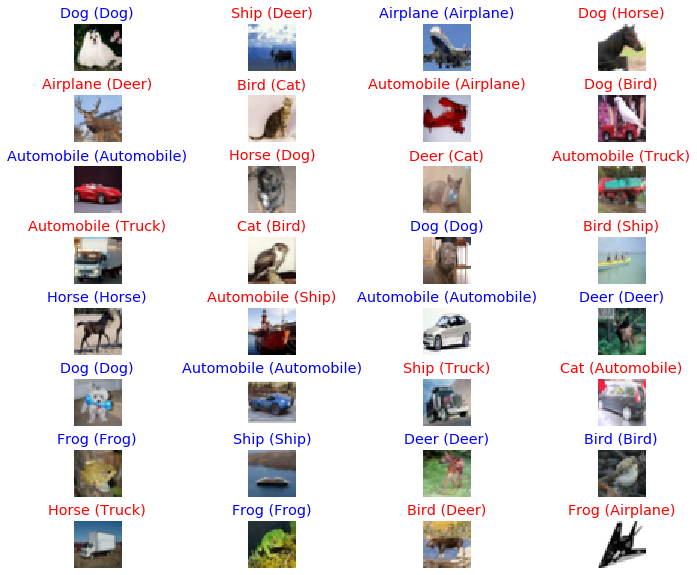

In [0]:
plt.figure(figsize=(12, 10))

for n in range(BATCH_SIZE):
  plt.subplot(8, 4, n+1)
  plt.subplots_adjust(hspace=0.5)
  plt.imshow(test_img[n])
  color = "blue" if predicted_ids[n] == test_label[n] else "red"
  plt.title(label="{} ({})".format(predicted_class_names[n].title(), 
                                   class_names[test_label][n].title()), color=color)
  plt.grid(False)
  plt.axis('off')

plt.show()